In [37]:
#load and vis a few seqmented images in the images_CNN folder
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image, ImageSequence
img_list = glob.glob('images_CNN/F?_im.TIF')+glob.glob('images_CNN/F??_im.TIF')
img_list = sorted(img_list)
mask_list = glob.glob('images_CNN/*mask.h5')
mask_list = sorted(mask_list)
fluo_gfp = glob.glob('images_CNN/*GFP_im.TIF')
fluo_gfp = sorted(fluo_gfp)
fluo_rfp = glob.glob('images_CNN/*RFP_im.TIF')
fluo_rfp = sorted(fluo_rfp)
print( len(img_list), len(mask_list) , len(fluo_gfp), len(fluo_rfp  )   )
dataset = {}
for i in range(len(img_list)):
    dataset[i] = { 'img': img_list[i], 'mask': mask_list[i], 'gfp': fluo_gfp[i], 'rfp': fluo_rfp[i]  }
print(dataset)



11 11 11 11
{0: {'img': 'images_CNN/F10_im.TIF', 'mask': 'images_CNN/F10_mask.h5', 'gfp': 'images_CNN/F10_GFP_im.TIF', 'rfp': 'images_CNN/F10_RFP_im.TIF'}, 1: {'img': 'images_CNN/F11_im.TIF', 'mask': 'images_CNN/F11_mask.h5', 'gfp': 'images_CNN/F11_GFP_im.TIF', 'rfp': 'images_CNN/F11_RFP_im.TIF'}, 2: {'img': 'images_CNN/F1_im.TIF', 'mask': 'images_CNN/F1_mask.h5', 'gfp': 'images_CNN/F1_GFP_im.TIF', 'rfp': 'images_CNN/F1_RFP_im.TIF'}, 3: {'img': 'images_CNN/F2_im.TIF', 'mask': 'images_CNN/F2_mask.h5', 'gfp': 'images_CNN/F2_GFP_im.TIF', 'rfp': 'images_CNN/F2_RFP_im.TIF'}, 4: {'img': 'images_CNN/F3_im.TIF', 'mask': 'images_CNN/F3_mask.h5', 'gfp': 'images_CNN/F3_GFP_im.TIF', 'rfp': 'images_CNN/F3_RFP_im.TIF'}, 5: {'img': 'images_CNN/F4_im.TIF', 'mask': 'images_CNN/F4_mask.h5', 'gfp': 'images_CNN/F4_GFP_im.TIF', 'rfp': 'images_CNN/F4_RFP_im.TIF'}, 6: {'img': 'images_CNN/F5_im.TIF', 'mask': 'images_CNN/F5_mask.h5', 'gfp': 'images_CNN/F5_GFP_im.TIF', 'rfp': 'images_CNN/F5_RFP_im.TIF'}, 7: {'i

In [38]:

import skimage.measure as measure
import copy

def output_contours( m , cl , verbose = False):
    contours = measure.find_contours(m, .9)
    if verbose:
        plt.imshow(m)
        for n, contour in enumerate(contours):
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
        plt.show()

    #output contours of each mask to file
    #divide x and y coordinates by total image size
    #to get values between 0 and 1  
    #<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
    lines = []
    for c in contours:
        coords = []
        for i in range(0,c.shape[0]):
            coords.append( float(c[i][0]) / m.shape[0] )
            coords.append( float(c[i][1]) / m.shape[1] )
        line = str(cl) + ' ' + ' '.join([str(c) for c in coords]) + '\n'
        lines.append(line)
    return lines

def split_mask(mask, crop = 1024):
    #custom encoding with 3 classes
    mask = mask[0:crop, 0:crop]
    mask1 = copy.deepcopy(mask)
    mask1[ (mask1 > 0) & (mask1 < 1000)] =  1
    mask1[mask1 > 1] = 0 

    mask2 = copy.deepcopy(mask)
    mask2[mask2 == 1] = 0
    mask2[ (mask2 > 1000) & (mask2 < 2000)] =  1
    mask2[mask2 > 1] = 0

    mask3 = copy.deepcopy(mask)
    mask3[mask3 == 1] = 0
    mask3[ (mask3 >= 2000) ] =  1
    mask3[mask3 > 1] = 0
    return mask1, mask2, mask3

def mask2contourfile( mask , outputfile , verbose = False):
    if type(mask) == list:
        m1,m2,m3 = mask
    else:
        m1, m2, m3 = split_mask(mask)
    lines = output_contours(m1, 0 , verbose = verbose)
    lines += output_contours(m2, 1, verbose = verbose)
    lines += output_contours(m3, 2, verbose = verbose)
    
    with open(outputfile, 'w') as f:
        for l in lines:
            f.write(l)
    return  outputfile


In [39]:
#clean finaldataset folder
import shutil
overwite = True
if overwite:
    try:
        shutil.rmtree('./datasets/')
    except:
        pass
    os.mkdir('./datasets/')
    os.mkdir('./datasets/train')
    os.mkdir('./datasets/train/images/')
    os.mkdir('./datasets/train/labels/')
    
    os.mkdir('./datasets/test')
    os.mkdir('./datasets/test/images/')
    os.mkdir('./datasets/test/labels/')
    
    os.mkdir('./datasets/val/')
    os.mkdir('./datasets/val/images')
    os.mkdir('./datasets/val/labels')


In [40]:
#stack equivalent frames together from img, gfp and rfp and transform them to a jpg image
import cv2
import numpy as np
import os
import tqdm

verbose = False
crop = 1024

def yield_frames(img,crop=1024 , verbose = False):
    for i, page in enumerate(ImageSequence.Iterator(img)):
        if verbose == True:
            plt.imshow(np.array(page))
            plt.show()
        page = np.array(page)[0:crop, 0:crop]
        yield page
count = 0

for sample in dataset:
    maskfile = dataset[sample]['mask']
    maskh5 = h5py.File(maskfile, 'r')
    for group in maskh5.keys():
        for frame in maskh5[group]:
            mask = np.array( maskh5[group][frame] ,  dtype = np.uint16 )
            
            if np.sum(mask) > 0 :
                mask =  mask[0:crop, 0:crop]
                dataset[sample]['maskmatrix'] = mask
                print( group, frame)
                print(np.unique(mask) )
                if verbose == True:
                    plt.imshow(mask)
                    plt.show()
                converted = mask2contourfile(mask, maskfile +'converted.txt' , verbose = verbose)
                dataset[sample]['mask_poly'] = converted
                break

    print('loading img')
    img = Image.open(dataset[sample]['img'])
    img = [frame for frame in yield_frames(img,verbose=verbose)]
    print('loading gfp')

    gfp = Image.open(dataset[sample]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,verbose=verbose)]
    
    print('loading rfp')
    rfp = Image.open(dataset[sample]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,verbose=verbose)]
    dataset[sample]['stack']= []
    dataset[sample]['stack_mat'] ={}
    #stack the frames together
    for i in tqdm.tqdm(range(len(img))):
        im = np.stack([img[i], gfp[i], rfp[i]], axis=-1)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        
        cv2.imwrite('./datasets/train/images/img_'+str(count)+'.png', im )
        dataset[sample]['stack_mat'][i] = im
        dataset[sample]['stack'].append('./datasets/train/images/img_'+str(count)+'.png')
        
        #save the correct mask file
        shutil.copyfile(dataset[sample]['mask_poly'], './datasets/train/labels/img_'+str(count)+'.txt' )
        count += 1

FOV0 T5
[   0    1    2    4 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1020 1021 2001 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1020 1021 1022 1023 2001 2002]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.75it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8   10   11 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1031 1032 1033 1034 1035 1037 1038 1039 1042 1043 1044 2001 2002 2003 2004 2005 2006 2007 2008 2009 2011]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.73it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   13 1001 1002 1003 1004 1007 1008 1009 1010 1013 1014 1015 1016 1017 1018 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1059
 1060 1061 1062 1063 1064 1065 1066 1075 1076 1077 1078 2001 2002 2003 2006]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1028 1032 1033 1039 1040 2001 2002 2003 2004 2005 2006 2007 2008 2009 2014]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.74it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   21 1001 1003 1004 1005 1006 1007 1009 1010 1011 1012 1013 1014 1015 1017 1018 1019 1020 1021 1022 1023 1026 1027 1028 1029 1030 1031 1032 1033 1034 1036 1037 1038 1039 1051 2001 2002 2003 2004 2005 2011 2012]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


FOV0 T5
[   0    1    2    3    6    7 1001 1002 1003 1004 1005 1006 1007 1008 1012 1013 1015 1016 1017 1019 1020 1021 1022 1024 2001 2002 2003 2004 2006]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.82it/s]


FOV0 T5
[   0    1    2 1001 1002 1003 1004 1005 1007]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.93it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.51it/s]


FOV0 T5
[   0    1    2    4 1001 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1018 1019 1020 1021 1022 1023 1025 1029 1035 2001 2002]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


FOV0 T5
[   0    1    2    3    4 1001 1002 1003 1004 1005 1006 1007 1008 1009 1011 1012 1013 1014 1015 1016 1023 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


loading img
loading gfp
loading rfp


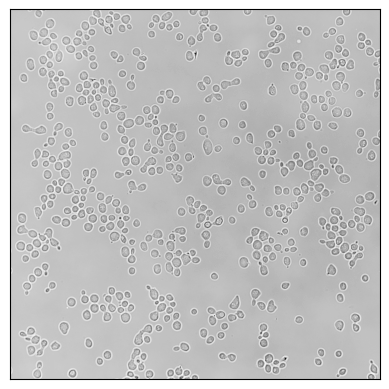

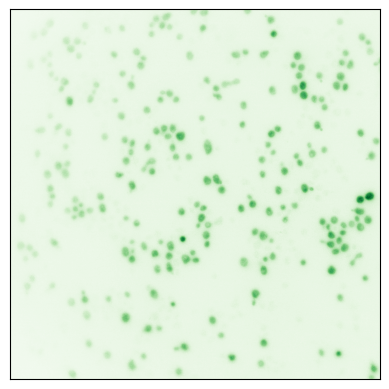

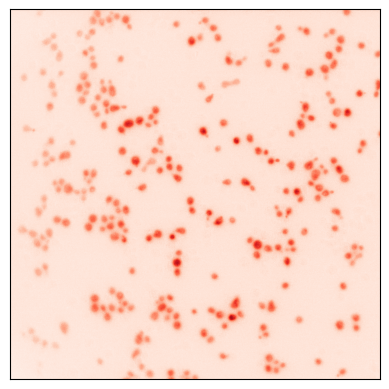

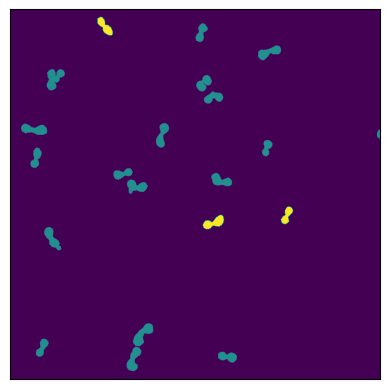

In [41]:
check_example = True
import matplotlib.pyplot as plt
%matplotlib inline

if check_example == True:
    print('loading img' )
    img = Image.open(dataset[0]['img'])
    img = [frame for frame in yield_frames(img,verbose=False)]
    print('loading gfp')

    gfp = Image.open(dataset[0]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,verbose=False)]
    
    print('loading rfp')
    rfp = Image.open(dataset[0]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,verbose=False)]

    ax = plt.imshow( img[0] , cmap = 'Greys')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    ax = plt.imshow( gfp[0] , cmap = 'Greens')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    ax = plt.imshow( rfp[0] , cmap = 'Reds')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    
    ax = plt.imshow( dataset[0]['maskmatrix'] )
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    



In [42]:
from sklearn.preprocessing import RobustScaler
import numpy as np
import pickle

def scale_image_with_robust_scaler(scaler,image):
    """
    Scale the image pixel values to be in the range 0-255 using RobustScaler.

    Args:
    - image: A NumPy array of shape (height, width, channels) or (height, width) for grayscale images.

    Returns:
    - Scaled image as a NumPy array with the same shape as the input, with values scaled to 0-255.
    """
    
    
    # Flatten the image to 2D if it is 3D, because RobustScaler expects 2D input
    original_shape = image.shape
    if len(original_shape) == 3:
        image = image.reshape(-1, original_shape[2])
    else:
        image = image.reshape(-1, 1)

    # Fit and transform the image data
    scaled_image = scaler.transform(image)

    # Scale the data back to 0-255 range
    scaled_image = (scaled_image - scaled_image.min()) / (scaled_image.max() - scaled_image.min()) * 255

    # Ensure the scaled values are of type uint8
    scaled_image = scaled_image.astype(np.uint8)

    # Reshape the scaled image back to its original shape
    scaled_image = scaled_image.reshape(original_shape)

    return scaled_image


# Initialize the RobustScaler
scaler_bf = RobustScaler()
scaler_rfp = RobustScaler()
scaler_gfp = RobustScaler()

images_bf = np.stack([ dataset[sample]['stack_mat'][frame][:,:,0] for sample in dataset for frame in dataset[sample]['stack_mat'] ])
images_gfp = np.stack([ dataset[sample]['stack_mat'][frame][:,:,1] for sample in dataset for frame in dataset[sample]['stack_mat'] ])
images_rfp = np.stack([ dataset[sample]['stack_mat'][frame][:,:,2] for sample in dataset for frame in dataset[sample]['stack_mat'] ])

print('stacks' , images_bf.shape ,images_gfp.shape , images_rfp.shape )

image_stack_bf = images_bf.reshape(-1, images_bf.shape[2])
image_stack_rfp = images_rfp.reshape(-1, images_rfp.shape[2]) 
image_stack_gfp = images_gfp.reshape(-1, images_gfp.shape[2])  

print( 'fitting scalers ' ) 
scaler_bf.fit(image_stack_bf)
scaler_rfp.fit(image_stack_rfp)
scaler_gfp.fit(image_stack_gfp)

scalers = [scaler_bf, scaler_rfp, scaler_gfp]
print('scalers', scalers)
with open('scalers.pkl' , 'wb') as scalerdump:
    scalerdump.write(pickle.dumps(scalers))

stacks (77, 1024, 1024) (77, 1024, 1024) (77, 1024, 1024)
fitting scalers 
scalers [RobustScaler(), RobustScaler(), RobustScaler()]


In [43]:
#apply data augmentation
#image augmentation for training

import cv2
import random
import numpy as np

def random_rotation(image, masks, angle_range):
    angle = random.uniform(-angle_range, angle_range)
    image =  Image.fromarray(  np.array( np.ones(image.shape)*256 - Image.fromarray(image)).astype(np.uint8) )
    image = image.rotate(angle)
    masks = [ Image.fromarray(m) for m in masks ]
    masks = [ m.rotate(angle) for m in masks ]
    return np.array(image), masks

def random_flip(image, masks):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        masks = [ cv2.flip(np.array(m), 1) for m in masks]
    return image, masks

def random_augmentation(image, masks, angle_range, crop_size):
    
    image, masks = random_rotation(image, masks, angle_range)
    
    image, masks = random_flip(image, masks)
   
    
    #image, mask = random_crop(image, mask, crop_size)
    return image, masks

#resize to original size
def resize(image, mask, size):
    image = cv2.resize(image, size)
    mask = cv2.resize(mask, size)
    return image, mask

#apply augmentation and then resize to original size
def augment_and_resize(image, masks, angle_range=180, crop_size=900, size=[1024,1024]):
    image = image.astype(np.uint8)
    image, masks = random_augmentation(image, masks, angle_range, crop_size)
    masks = [np.array(m) for m in masks ]
    #image, masks = resize(image, masks, size)
    return image, masks

In [44]:

augmented_folder = 'augmented/'

In [45]:
import shutil
overwite = True
if overwite:
    try:
        shutil.rmtree(augmented_folder)
    except:
        pass
    os.mkdir(augmented_folder)
    os.mkdir(augmented_folder+'train')
    os.mkdir(augmented_folder+'train/images/')
    os.mkdir(augmented_folder+'train/labels/')
    
    os.mkdir(augmented_folder +'test')
    os.mkdir(augmented_folder+'test/images/')
    os.mkdir(augmented_folder + 'test/labels/')
    
    os.mkdir(augmented_folder +'val/')
    os.mkdir(augmented_folder +'val/images')
    os.mkdir(augmented_folder + 'val/labels')


In [46]:
verbose = False
import tqdm 
x_augment = 10
augmented = {}

count = 0
for sample in tqdm.tqdm(dataset):
    augmented[sample] ={}
    for frame in dataset[sample]['stack_mat']:
        image = dataset[sample]['stack_mat'][frame]
        mask = dataset[sample]['maskmatrix']
        masks = split_mask(mask)
        for i in range(x_augment):
            img , masks = augment_and_resize(image,masks)
            
            for m in masks:
                m[m>0] = 1
                
            if count < 10 and verbose == True:
                plt.imshow( img[:,:,0] , cmap = 'Greys')
                plt.colorbar( location = 'left')
                plt.show()
            augmented[sample]['mask'] = mask
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(augmented_folder+'train/images/img_'+str(count)+'.png', im )
            augmented[sample]['img'] = augmented_folder+'train/images/img_'+str(count)+'.png'
            m1,m2,m3 = masks
            lines = output_contours(m1, 0 , verbose = verbose)
            lines += output_contours(m2, 1, verbose = verbose)
            lines += output_contours(m3, 2, verbose = verbose)
            with open(augmented_folder + 'train/labels/img_'+ str(count)+ '.txt', 'w') as f:
                for l in lines:
                    f.write(l)
            augmented[sample]['mask_poly'] = augmented_folder  +'train/labels/img_'+ str(count)+ '.txt'
            #add polygons
            count+=1
            

100%|██████████| 11/11 [02:40<00:00, 14.55s/it]


In [52]:
#move a fraction of the training data and corresponding labels to val
import random
import shutil
import os

datasetdir = augmented_folder

files = os.listdir(datasetdir +'train/images/')
print(files[0:100], '...')
random.shuffle(files)
val_files = files[:int(len(files)*.1)]
for f in val_files:
    shutil.move(datasetdir + 'train/images/'+f, datasetdir+'val/images/'+f)
    shutil.move(datasetdir +'train/labels/'+f.replace('.png', '.txt'), datasetdir + 'val/labels/'+f.replace('.png', '.txt'))

    
files = os.listdir(datasetdir+'train/images/')
random.shuffle(files)

test_files = files[:int(len(files)*.1)]
for f in test_files:
    shutil.move(datasetdir + 'train/images/'+f, datasetdir + 'test/images/'+f)
    shutil.move(datasetdir + 'train/labels/'+f.replace('.png', '.txt'), datasetdir + 'test/labels/'+f.replace('.png', '.txt'))



['img_476.png', 'img_116.png', 'img_109.png', 'img_21.png', 'img_299.png', 'img_246.png', 'img_559.png', 'img_395.png', 'img_308.png', 'img_340.png', 'img_458.png', 'img_55.png', 'img_569.png', 'img_523.png', 'img_43.png', 'img_630.png', 'img_350.png', 'img_361.png', 'img_379.png', 'img_356.png', 'img_84.png', 'img_81.png', 'img_59.png', 'img_675.png', 'img_86.png', 'img_60.png', 'img_65.png', 'img_17.png', 'img_724.png', 'img_588.png', 'img_309.png', 'img_332.png', 'img_430.png', 'img_254.png', 'img_405.png', 'img_560.png', 'img_28.png', 'img_471.png', 'img_539.png', 'img_127.png', 'img_720.png', 'img_52.png', 'img_568.png', 'img_328.png', 'img_270.png', 'img_22.png', 'img_258.png', 'img_101.png', 'img_589.png', 'img_245.png', 'img_682.png', 'img_706.png', 'img_76.png', 'img_293.png', 'img_369.png', 'img_316.png', 'img_274.png', 'img_433.png', 'img_158.png', 'img_105.png', 'img_260.png', 'img_698.png', 'img_69.png', 'img_557.png', 'img_502.png', 'img_187.png', 'img_238.png', 'img_47.p

In [53]:
#create traininging yaml file for the dataset

outyaml = """
train: train
val: val
test: test

names: 
    0: f
    1: h
    2: l
"""

with open('./dataset.yaml', 'w') as f:
    f.write(outyaml)


In [54]:
from ultralytics import YOLO
modelpath = 'yolov8n-seg_yfusion.pt'
import os


overwrite = True
if os.path.exists(modelpath) and overwrite == False:
    model = YOLO(modelpath)
else:
    #train the model
    model = YOLO("yolov8n-seg.pt")

In [ ]:
train = True
if train == True:
    results = model.train(
            batch=1,
            device=0,
            data='./dataset.yaml',
            epochs=5000,
            imgsz=1024,
            
        )

Ultralytics YOLOv8.1.10 🚀 Python-3.12.1 torch-2.2.0 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=./dataset.yaml, epochs=5000, time=None, patience=50, batch=1, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train19, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/train/labels... 506 images, 0 backgrounds, 0 corrupt: 100%|██████████| 506/506 [00:04<00:00, 118.11it/s]


train: New cache created: /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/train/labels.cache


val: Scanning /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/val/labels... 139 images, 0 backgrounds, 0 corrupt: 100%|██████████| 139/139 [00:02<00:00, 65.66it/s]


val: New cache created: /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/val/labels.cache


/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/torch/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Plotting labels to runs/segment/train19/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/segment/train19
Starting training for 5000 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     1/5000      9.44G       3.64      5.325      4.608      2.729         18       1024: 100%|██████████| 506/506 [01:35<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:15<00:00,  4.41it/s]

                   all        139      18055          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     2/5000      7.71G      3.364      5.081      4.318      2.363         42       1024: 100%|██████████| 506/506 [01:33<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:15<00:00,  4.49it/s]

                   all        139      18055          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     3/5000      19.2G      3.265      5.139        4.1      2.226         75       1024: 100%|██████████| 506/506 [01:32<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:19<00:00,  3.64it/s]

                   all        139      18055    0.00181    0.00403   0.000977   0.000244   0.000295   0.000658   0.000151   1.78e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     4/5000      5.38G        3.2      5.071      3.986      2.205         26       1024: 100%|██████████| 506/506 [01:32<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:19<00:00,  3.67it/s]


                   all        139      18055    0.00103    0.00334   0.000532   0.000162   0.000452    0.00147   0.000228   3.34e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     5/5000      8.73G      3.174      5.014       3.91      2.149         57       1024: 100%|██████████| 506/506 [01:32<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:17<00:00,  4.01it/s]


                   all        139      18055    0.00193    0.00548   0.000985    0.00025   0.000372    0.00105   0.000188   2.83e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     6/5000      7.53G      3.154       4.95      3.847      2.141         63       1024: 100%|██████████| 506/506 [01:32<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:18<00:00,  3.80it/s]


                   all        139      18055     0.0022    0.00714    0.00114   0.000292   0.000219   0.000711   0.000111   2.09e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     7/5000      11.4G      3.083       4.99      3.807      2.117         59       1024: 100%|██████████| 506/506 [01:32<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:17<00:00,  3.96it/s]


                   all        139      18055     0.0025    0.00566    0.00128   0.000318   0.000404    0.00132   0.000205   2.67e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     8/5000      13.8G      3.121      4.911      3.815      2.109         29       1024: 100%|██████████| 506/506 [01:32<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:17<00:00,  3.95it/s]


                   all        139      18055    0.00188    0.00619   0.000966   0.000244   0.000392    0.00129   0.000197   2.57e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     9/5000      8.43G      3.066      4.916       3.79      2.074         93       1024:  73%|███████▎  | 370/506 [01:07<00:27,  4.90it/s]

In [ ]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train14/train_batch0.jpg")


from IPython.display import Image as show_image
show_image(filename="runs/segment/train14/val_batch0_labels.jpg")

In [6]:
#save model
model.save('yolov8n-seg_yfusion.pt')

In [ ]:
from ultralytics import YOLO


In [14]:
#visualize predicitions for the validation set

import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm 

my_model = YOLO('runs/segment/train5/weights/best.pt')
results = list(my_model('datasets/test/images/img_57.png', conf=0.0))
result = np.asarray( results[0].conf.detach())
def retdf(model, predfile):
    resdict = { i:{ c:result[row,i] for i,c in enumerate(classes) } for i in result.shape[0] }
    resdf = pd.DataFrame(resdict)
    resdf['file'] = predfile
    return resdf

predfiles = glob.glob('*/')
global_resdf =  pd.concat([ retdf(my_model(imgfile, conf=0.0) ) for imgfile in tqdm.tdm(predfiles) ])

print(global_resdf )


image 1/1 /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/test/images/img_57.png: 1024x1024 103 fs, 70 hs, 127 ls, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 66.2ms postprocess per image at shape (1, 3, 1024, 1024)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'f', 1: 'h', 2: 'l'}
obb: None
orig_img: array([[[ 0,  0, 27],
        [ 0,  0, 28],
        [ 0,  0, 28],
        ...,
        [ 0,  0, 27],
        [ 0,  0, 28],
        [ 0,  0, 28]],

       [[ 0,  0, 27],
        [ 0,  0, 29],
        [ 0,  0, 28],
        ...,
        [ 0,  0, 28],
        [ 0,  0, 28],
        [ 0,  0, 28]],

       [[ 0,  0, 27],
        [ 0,  0, 28],
        [ 0,  0, 29],
        ...,
        [ 0,  0, 28],
        [ 0,  0, 28],
        [ 0,  0, 28]],

       ...,

       [[ 0,  0, 27],
        [ 0,  0, 27],
        [ 0,  0, 26],
        .

In [ ]:
print(results)

In [4]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train5/val_batch0_labelsYOLOjpg")

show_image(filename="runs/segment/train5/MaskP_curve.png")

show_image(filename="runs/segment/train5/results.png")



ValueError: Cannot embed the 'runs/segment/train5/val_batch0_labelsyolojpg' image format

In [ ]:
#augment dataset and dump to disk in pt format
